## Purpose: See how much the anguler information (adding $\theta$) is effective in detecting dark matter signals.
#### Motivation: In [Advanced Pseudo Experiment 2](./Advanced_Pseudo_Experiment_2.ipynb), the use of 2D J profile returns a higher TS value compared to one from 1D J profile.

In [2]:
%load_ext autoreload
%autoreload 2
from DarkMatter import *

Welcome to JupyROOT 6.23/01


In [3]:
from scipy import optimize

linear = lambda x, a, b: a*x+b
gaus = lambda x, N, x0, sigma: N*np.exp(-(x-x0)**2/(2*sigma**2))

def gaus_fit(x, y):
    par, cov = optimize.curve_fit(gaus, x, y, p0 = (max(y), np.median(x), 2))
    return np.asarray(par)

In [4]:
import ctypes
from DarkMatter.Likelihood.mle import MLE
from tqdm.notebook import tqdm

### 1. Preparation

In [10]:
dwarf = "segue_1"
decay = "tt"
package = "EventDisplay"
sigma = -22.5
jSeed = defaultNum[dwarf]

#23.8, 22.8, 21.6

hOn, hOff, Non, Noff, events, alpha = Likelihood.eventdisplay.readData(dwarf, addTheta=True, full_output=True, ext=True)
events = Likelihood.eventdisplay.readData(dwarf, rawdata=True, ext=True)
mass = np.logspace(2, 4.5, 20)
hOn = {}
ts_dist = {}


for M in mass:
    ts_dist[M] = []
    hOn_fake = hOff.Clone()
    hOn_fake.SetTitle("Fake On region")
    hOn_fake.SetName("FakeOnregion")
    hOn_fake.Reset()    
    hSignal = Likelihood.combinedCalcSignal(dwarf, M, package, decay=decay, addTheta=True, sigma=sigma, jSeed=jSeed, ext=True)
    
    for i in range(hOn_fake.GetNbinsX()):
        for j in range(hOn_fake.GetNbinsY()):
            tot = hOff.GetBinContent(i+1, j+1) + hSignal.GetBinContent(i+1, j+1)
            hOn_fake.SetBinContent(i+1, j+1, tot)

    hOn[int(M)] = [hSignal.Clone(), hOn_fake.Clone(), LiMaSiginficance(hSignal.Integral()+Noff*alpha, Noff, alpha=0.167)]
    print(int(M), hSignal.Integral(), LiMaSiginficance(hSignal.Integral()+Noff*alpha, Noff, alpha=0.167))

100 4.811545474065084 2.1510262107241327


KeyboardInterrupt: 

Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).


### 2. Run simulations

In [65]:
runs = 200
pbar = tqdm(total=len(mass)*runs)
ts_dist = {}
for M in mass:
    ts_dist[M] = []
e, th = map(ctypes.c_double, (0.18, 0.20))
eMin = min(events[events[:,2]==0.][:,0])
for M in mass:
    Non = hOn[int(M)][0].Integral()+Noff*alpha
    for n in range(runs):
        
        
        fake_events = []
        fake_Non = np.random.poisson(Non)
        for m in range(fake_Non):
            while True:
                hOn[int(M)][1].GetRandom2(e, th)
                if e.value>=eMin:
                    break

            fake_events.append([e.value, th.value, 1, 1])

        fake_events = fake_events+events[events[:,2]==0.][:,:4].tolist()
        fake_events = np.asarray(fake_events)

        mle_1d = MLE(dwarf, M, package, decay=decay, addTheta=False, 
                     averagedIRF=True, seed=jSeed, ext=True,
                     test=True, events = fake_events[fake_events[:,2]==1.], 
                     N_on=fake_Non, bkgModel="ex", verbose=False) 
        mle_1d.minuit(method=2, upperLimit=False)

        mle_2d = MLE(dwarf, M, package, decay=decay, addTheta=True, 
                     averagedIRF=True, seed=jSeed, ext=True,
                     hSignal = hOn[int(M)][0], test=True, events = fake_events[fake_events[:,2]==1.], 
                     Non = fake_Non, bkgModel="ex", signu=sigma, verbose=False) 
        mle_2d.minuit(method=2, upperLimit=False)

        ts_dist[M].append([(mle_1d.ts if mle_1d.ts>0 else 0), (mle_2d.ts if mle_2d.ts>0 else 0), LiMaSiginficance(fake_Non, Noff, alpha=0.167)])

        pbar.update(1)
    ts_dist[M] = np.asarray(ts_dist[M])
    print("{:.2f}".format(M/1000.), np.median(ts_dist[M][:,0]), np.median(ts_dist[M][:,1]), np.median(ts_dist[M][:,2]))


  0%|          | 0/4000 [00:00<?, ?it/s]

[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
0.10 0.0 0.0 1.086952604602018
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
0.14 0.0 0.0 1.0711646136891675
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
0.18 0.0 0.0 1.150062779458051
0.25 0.0 0.0 2.5401681069677506
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
0.34 0.3626423

In [66]:
np.save("{}_tt_{:.0f}_{:.0f}_bbar".format(dwarf, abs(sigma), runs), ts_dist)

In [74]:
"{}_tt_{:.0f}_{:.0f}_bbar".format(dwarf, abs(sigma), runs)

'ursa_minor_tt_22_200_bbar'

### 3. Take the median value

In [115]:
ts_dist = np.load("segue_1_tt_23_200.npy", allow_pickle=True).item()

m_ts = []
for M in mass:
    ts_dist[M] = np.asarray(ts_dist[M])
    m_ts.append([M, np.percentile(ts_dist[M][:,0], 50), np.percentile(ts_dist[M][:,1], 50), 
                   np.percentile(ts_dist[M][:,0], 16),np.percentile(ts_dist[M][:,0], 84),
                   np.percentile(ts_dist[M][:,1], 16),np.percentile(ts_dist[M][:,1], 84),
                   np.percentile(ts_dist[M][:,2], 50),])
m_ts2 = np.asarray(m_ts)

ts_dist = np.load("ursa_minor_tt_22_200.npy", allow_pickle=True).item()

m_ts = []
for M in mass:
    ts_dist[M] = np.asarray(ts_dist[M])
    m_ts.append([M, np.percentile(ts_dist[M][:,0], 50), np.percentile(ts_dist[M][:,1], 50), 
                   np.percentile(ts_dist[M][:,0], 16),np.percentile(ts_dist[M][:,0], 84),
                   np.percentile(ts_dist[M][:,1], 16),np.percentile(ts_dist[M][:,1], 84),
                   np.percentile(ts_dist[M][:,2], 50),])
m_ts = np.asarray(m_ts)

Text(1000, 2, '$b\\bar{b}$ channel')

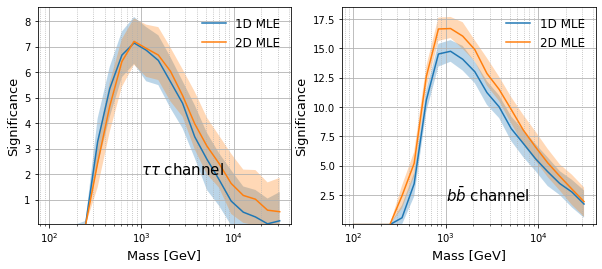

In [103]:
f, ax = plt.subplots(1,2, figsize=(10, 4))
etc = ax[0].plot(m_ts[:,0], np.sqrt(m_ts[:,1]), label=r"1D MLE")
ax[0].fill_between(m_ts[:,0], np.sqrt(m_ts[:,3]),np.sqrt(m_ts[:,4]), alpha=0.3)
etc = ax[0].plot(m_ts[:,0], np.sqrt(m_ts[:,2]), label=r"2D MLE")
ax[0].fill_between(m_ts[:,0], np.sqrt(m_ts[:,5]),np.sqrt(m_ts[:,6]), alpha=0.3)
#etc = ax.plot(m_ts[:,0], m_ts[:,7], label=r"Li&Ma")
ax[0].set_xscale("log")
ax[0].grid(which="major")
ax[0].grid(which="minor", ls=":")
ax[0].legend(fontsize=12, frameon=False)
ax[0].set_xlabel("Mass [GeV]", fontsize=13)
ax[0].set_ylabel("Significance", fontsize=13)
ax[0].set_ylim(5e-2)
ax[0].text(1000, 2, r"$\tau\tau$ channel", fontsize=15)

etc = ax[1].plot(m_ts2[:,0], np.sqrt(m_ts2[:,1]), label=r"1D MLE")
ax[1].fill_between(m_ts2[:,0], np.sqrt(m_ts2[:,3]),np.sqrt(m_ts2[:,4]), alpha=0.3)
etc = ax[1].plot(m_ts2[:,0], np.sqrt(m_ts2[:,2]), label=r"2D MLE")
ax[1].fill_between(m_ts2[:,0], np.sqrt(m_ts2[:,5]),np.sqrt(m_ts2[:,6]), alpha=0.3)
#etc = ax.plot(m_ts[:,0], m_ts[:,7], label=r"Li&Ma")
ax[1].set_xscale("log")
ax[1].grid(which="major")
ax[1].grid(which="minor", ls=":")
ax[1].legend(fontsize=12, frameon=False)
ax[1].set_xlabel("Mass [GeV]", fontsize=13)
ax[1].set_ylabel("Significance", fontsize=13)
ax[1].set_ylim(5e-2)
ax[1].text(1000, 2, r"$b\bar{b}$ channel", fontsize=15)

Text(0.35, 0.1, 'Segue 1')

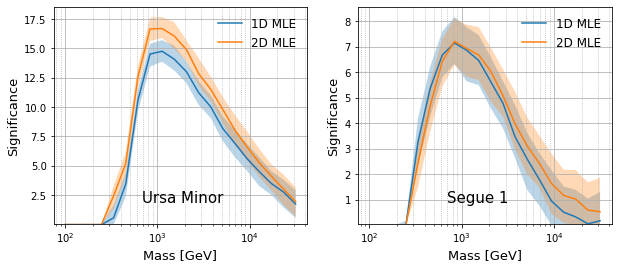

In [116]:
f, ax = plt.subplots(1,2, figsize=(10, 4))
etc = ax[0].plot(m_ts[:,0], np.sqrt(m_ts[:,1]), label=r"1D MLE")
ax[0].fill_between(m_ts[:,0], np.sqrt(m_ts[:,3]),np.sqrt(m_ts[:,4]), alpha=0.3)
etc = ax[0].plot(m_ts[:,0], np.sqrt(m_ts[:,2]), label=r"2D MLE")
ax[0].fill_between(m_ts[:,0], np.sqrt(m_ts[:,5]),np.sqrt(m_ts[:,6]), alpha=0.3)
#etc = ax.plot(m_ts[:,0], m_ts[:,7], label=r"Li&Ma")
ax[0].set_xscale("log")
ax[0].grid(which="major")
ax[0].grid(which="minor", ls=":")
ax[0].legend(fontsize=12, frameon=False)
ax[0].set_xlabel("Mass [GeV]", fontsize=13)
ax[0].set_ylabel("Significance", fontsize=13)
ax[0].set_ylim(5e-2)
ax[0].text(0.35, 0.1, r"Ursa Minor", fontsize=15, transform=ax[0].transAxes)

etc = ax[1].plot(m_ts2[:,0], np.sqrt(m_ts2[:,1]), label=r"1D MLE")
ax[1].fill_between(m_ts2[:,0], np.sqrt(m_ts2[:,3]),np.sqrt(m_ts2[:,4]), alpha=0.3)
etc = ax[1].plot(m_ts2[:,0], np.sqrt(m_ts2[:,2]), label=r"2D MLE")
ax[1].fill_between(m_ts2[:,0], np.sqrt(m_ts2[:,5]),np.sqrt(m_ts2[:,6]), alpha=0.3)
#etc = ax.plot(m_ts[:,0], m_ts[:,7], label=r"Li&Ma")
ax[1].set_xscale("log")
ax[1].grid(which="major")
ax[1].grid(which="minor", ls=":")
ax[1].legend(fontsize=12, frameon=False)
ax[1].set_xlabel("Mass [GeV]", fontsize=13)
ax[1].set_ylabel("Significance", fontsize=13)
ax[1].set_ylim(5e-2)
ax[1].text(0.35, 0.1, r"Segue 1", fontsize=15, transform=ax[1].transAxes)

### - Check averaged TS values for each cross section (1D vs 2D)
#### Result: It is more likely to detect the DM signal when we use 2D J profile (if exist).

In [5]:
dwarf = "segue_1"
decay = "tt"
package = "EventDisplay"
M = 1000

hOn, hOff, Non, Noff, events, alpha = Likelihood.eventdisplay.readData(dwarf, addTheta=True, ext=True, full_output=True)
events = Likelihood.eventdisplay.readData(dwarf, rawdata=True, ext=True)
mass = np.logspace(2, 4.5, 20)
hOn = {}
logl_dist = {}

jSeed = defaultNum[dwarf]
sigma_list = [-22.5]
for sigma in sigma_list:
    logl_dist[sigma] = []
    hOn_fake = hOff.Clone()
    hOn_fake.Reset()  
    hOn_fake.SetTitle("Fake On region")
    hOn_fake.SetName("FakeOnregion")
  
    hSignal = Likelihood.combinedCalcSignal(dwarf, M, package, jArray=True, jSeed=jSeed, decay=decay, ext=True, addTheta=True, sigma=sigma)
    
    for i in range(hOn_fake.GetNbinsX()):
        for j in range(hOn_fake.GetNbinsY()):
            tot = hOff.GetBinContent(i+1, j+1) + hSignal.GetBinContent(i+1, j+1)
            hOn_fake.SetBinContent(i+1, j+1, tot)

    hOn[sigma] = [hSignal.Clone(), hOn_fake.Clone(), Non+hSignal.Integral()]
    print(sigma, hSignal.Integral())

-22.5 1006.0392821775131


In [6]:
from DarkMatter.Likelihood.simulation import generateFakeEvents



In [ ]:
for i in range(runs):

    events = generateFakeEvents(dwarf, M, sigma, addTheta=True, poisson=True)
    

In [8]:
runs = 5
pbar = tqdm(total=len(sigma_list)*runs)
logl_dist_1d = {}
logl_dist_2d = {}

fit_dist_1d = {}
fit_dist_2d = {}

ul_dist_1d = {}
ul_dist_2d = {}

ts_dist_1d = {}
ts_dist_2d = {}

for sigma in sigma_list:
    logl_dist_1d[sigma] = []
    logl_dist_2d[sigma] = []
    fit_dist_1d[sigma] = []
    fit_dist_2d[sigma] = []
    ul_dist_1d[sigma] = []
    ul_dist_2d[sigma] = []
    ts_dist_1d[sigma] = []
    ts_dist_2d[sigma] = []

    
for sigma in sigma_list:
   
    for i in range(runs):

        events = generateFakeEvents(dwarf, M, sigma, addTheta=True, poisson=True)

        mle_1d = MLE(dwarf, M, package, decay=decay, addTheta=False, 
                     averagedIRF=True, seed=jSeed, ext=True,
                     test=True, events = events, 
                     N_on = np.size(events), bkgModel="ex", verbose=False) 
        mle_1d.minuit(method=2, upperLimit=True)

        mle_2d = MLE(dwarf, M, package, decay=decay, addTheta=True, 
                     averagedIRF=True, seed=jSeed, ext=True,
                     test=True, events = events, 
                     Non =  np.size(events), bkgModel="ex", signu=sigma, verbose=False) 
        mle_2d.minuit(method=2, upperLimit=True)

        logl_dist_1d[sigma].append(mle_1d.likelihood)
        logl_dist_2d[sigma].append(mle_2d.likelihood)
        
        fit_dist_1d[sigma].append(mle_1d.signu)
        fit_dist_2d[sigma].append(mle_2d.signu)
        
        ul_dist_1d[sigma].append(mle_1d.signu_ul)
        ul_dist_2d[sigma].append(mle_2d.signu_ul)
        
        ts_dist_1d[sigma].append(mle_1d.ts)
        ts_dist_2d[sigma].append(mle_2d.ts)
        
        
        pbar.update(1)
        
    logl_dist_1d[sigma] = np.asarray(logl_dist_1d[sigma])
    logl_dist_2d[sigma] = np.asarray(logl_dist_2d[sigma])
    
    fit_dist_1d[sigma] = np.asarray(fit_dist_1d[sigma])
    fit_dist_2d[sigma] = np.asarray(fit_dist_2d[sigma])
    
    ul_dist_1d[sigma] = np.asarray(ul_dist_1d[sigma])
    ul_dist_2d[sigma] = np.asarray(ul_dist_2d[sigma])
    
    ts_dist_1d[sigma] = np.asarray(ts_dist_1d[sigma])
    ts_dist_2d[sigma] = np.asarray(ts_dist_2d[sigma])

  0%|          | 0/5 [00:00<?, ?it/s]

ValueError: A value in x_new is below the interpolation range.

Warning in <TROOT::Append>: Replacing existing TH1: hg_2D (Potential memory leak).


In [ ]:
np.linspace(np.average(fit_dist_1d[sigma])-np.std(fit_dist_1d[sigma])*3,np.average(fit_dist_1d[sigma])+np.std(fit_dist_1d[sigma])*3, 50)

In [70]:
sigma_ts = []
for sigma in sigma_list:
    sigma_ts.append([sigma, np.percentile(ts_dist_1d[sigma], 50), np.percentile(ts_dist_2d[sigma], 50), 
                   np.percentile(ts_dist_1d[sigma], 16), np.percentile(ts_dist_2d[sigma], 84), 
                   np.percentile(ts_dist_1d[sigma], 16), np.percentile(ts_dist_2d[sigma], 84)])
sigma_ts = np.asarray(sigma_ts)

In [144]:
sigma_ts[:,1]

array([-2.09785503e-06, -3.63899744e-06, -2.23972893e-06,  6.47003967e+00,
        2.20453755e+02])

In [66]:
plt.errorbar(sigma_ts[:,0], sigma_ts[:,1], yerr=[sigma_ts[:,3]-sigma_ts[:,1], sigma_ts[:,5]-sigma_ts[:,1]], ls="")
plt.errorbar(sigma_ts[:,0], sigma_ts[:,2], yerr=[sigma_ts[:,4]-sigma_ts[:,2], sigma_ts[:,6]-sigma_ts[:,2]], ls="")
plt.yscale("log")

NameError: name 'sigma_ts' is not defined

[ 12.80087272 -22.56604168  -0.32596191]
[ 12.15088486 -22.53782035   0.33557637]


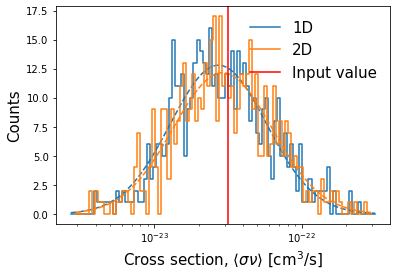

[ 5.04040404e+00 -1.25193552e+00 -2.85926348e+05]
[ 5.01008848e+00 -1.60401042e+03 -4.05902598e+05]


/Users/dtak/Software/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/dtak/Software/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0, 0.5, 'Counts')

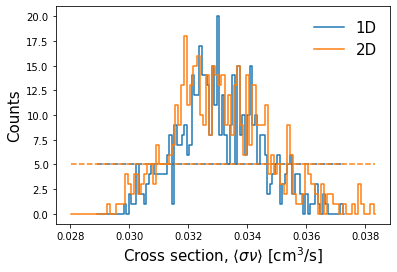

In [95]:
sigma=-22.5

y, x = np.histogram(fit_dist_1d[sigma][:,0], bins=np.linspace(np.average(fit_dist_1d[sigma][:,0])-np.std(fit_dist_1d[sigma][:,0])*3,np.average(fit_dist_1d[sigma][:,0])+np.std(fit_dist_1d[sigma][:,0])*3, 100))
etc = plt.step(10**center_pt(x), y, where="mid", label="1D")
plt.plot(10**center_pt(x), gaus(center_pt(x), *gaus_fit(center_pt(x), y)), color=etc[0].get_color(), ls="--")
print(gaus_fit(center_pt(x), y))
y, x = np.histogram(fit_dist_2d[sigma][:,0], bins=np.linspace(np.average(fit_dist_2d[sigma][:,0])-np.std(fit_dist_2d[sigma][:,0])*3,np.average(fit_dist_2d[sigma][:,0])+np.std(fit_dist_2d[sigma][:,0])*3, 100))
etc = plt.step(10**center_pt(x), y, where="mid", label="2D")
plt.plot(10**center_pt(x), gaus(center_pt(x), *gaus_fit(center_pt(x), y)), color=etc[0].get_color(), ls="--")
print(gaus_fit(center_pt(x), y))
plt.axvline(10**sigma, label="Input value", color="r")
plt.legend(fontsize=15, frameon=False)
#plt.xlim(2e-24, 3e-22)
plt.xscale("log")
plt.xlabel(r"Cross section, $\langle\sigma\nu\rangle$ [cm$^{3}$/s]", fontsize=15)
plt.ylabel(r"Counts", fontsize=15)
plt.show(block=False)

sigma=-22.5
y, x = np.histogram(fit_dist_1d[sigma][:,1], bins=np.linspace(np.average(fit_dist_1d[sigma][:,1])-np.std(fit_dist_1d[sigma][:,1])*3,np.average(fit_dist_1d[sigma][:,1])+np.std(fit_dist_1d[sigma][:,1])*3, 100))
etc = plt.step(center_pt(x), y, where="mid", label="1D")
plt.plot(center_pt(x), gaus(center_pt(x), *gaus_fit(center_pt(x), y)), color=etc[0].get_color(), ls="--")
print(gaus_fit(center_pt(x), y))
y, x = np.histogram(fit_dist_2d[sigma][:,1], bins=np.linspace(np.average(fit_dist_2d[sigma][:,1])-np.std(fit_dist_2d[sigma][:,1])*3,np.average(fit_dist_2d[sigma][:,1])+np.std(fit_dist_2d[sigma][:,1])*3, 100))
etc = plt.step(center_pt(x), y, where="mid", label="2D")
plt.plot(center_pt(x), gaus(center_pt(x), *gaus_fit(center_pt(x), y)), color=etc[0].get_color(), ls="--")
print(gaus_fit(center_pt(x), y))
#plt.axvline(0, label="Input value", color="r")
plt.legend(fontsize=15, frameon=False)
#plt.xlim(10**-23.1, 10**-21.2)
#plt.xscale("log")
plt.xlabel(r"Cross section, $\langle\sigma\nu\rangle$ [cm$^{3}$/s]", fontsize=15)
plt.ylabel(r"Counts", fontsize=15)


In [93]:
y

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  1,
        1,  4,  3,  2,  4,  2,  3,  4,  5,  5,  3,  7,  5,  5,  5,  6,  7,
       11,  9, 13, 18, 11, 13, 15, 16, 10,  9, 14,  8, 15, 14, 13, 14,  9,
       12,  8, 13, 15,  9,  6, 14,  7, 13,  9,  9,  9, 11,  4,  6,  4,  5,
        3,  2,  9,  6,  2,  1,  1,  2,  5,  4,  3,  2,  0,  3,  0,  2,  2,
        1,  1,  0,  1,  0,  0,  1,  0,  3,  1,  0,  0,  1,  0])

In [90]:
fit_dist_1d[sigma][:,1]

array([0.03101346, 0.03214952, 0.03436808, 0.03317581, 0.03197778,
       0.03241272, 0.03412732, 0.03240272, 0.03088079, 0.03300322,
       0.03189648, 0.03276106, 0.03201291, 0.03399663, 0.03196537,
       0.03185821, 0.03236525, 0.03044367, 0.03464812, 0.03481764,
       0.03332506, 0.03422265, 0.03417582, 0.03166798, 0.03133478,
       0.03366494, 0.03186772, 0.03213875, 0.03632031, 0.03142135,
       0.03251628, 0.0332087 , 0.0330112 , 0.03432693, 0.03382359,
       0.03137557, 0.03294221, 0.0330185 , 0.0340249 , 0.032553  ,
       0.03439327, 0.03444747, 0.03576477, 0.03300042, 0.03448893,
       0.03301901, 0.03218488, 0.03432297, 0.03190364, 0.03246714,
       0.03167654, 0.03410851, 0.03551057, 0.03256801, 0.03325474,
       0.03284111, 0.03254577, 0.03537609, 0.03112836, 0.03603872,
       0.03156951, 0.03268235, 0.03377918, 0.03113473, 0.03455022,
       0.03025228, 0.03355211, 0.03218585, 0.03226326, 0.03318782,
       0.033301  , 0.03411614, 0.03454323, 0.03187416, 0.03093

array([ 1.27405378e+02, -2.21017534e+01,  2.88463236e-02])

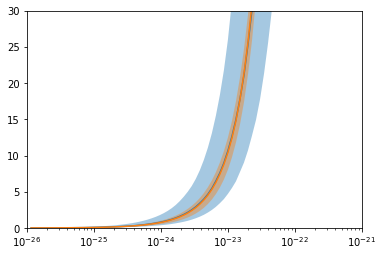

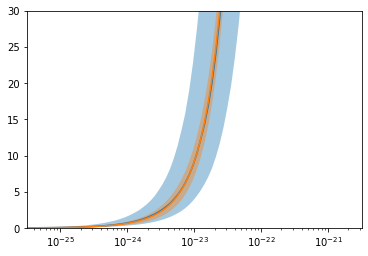

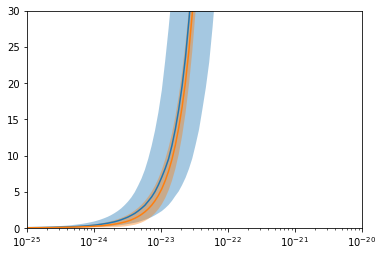

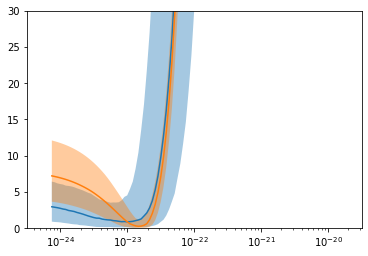

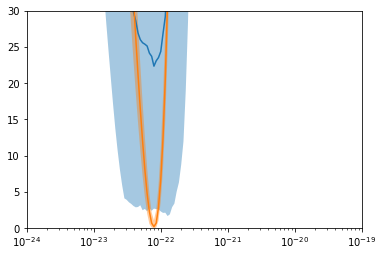

In [128]:
for sigma in sigma_list:
    temp_1d = []
    temp_2d = []
    bin_def = np.logspace(np.log10(max(max(logl_dist_1d[sigma][:,0][:,0]), max(logl_dist_2d[sigma][:,0][:,0]))), -20, 100)
    for i in range(500):
        lp_1d = interp1d(logl_dist_1d[sigma][i][:,0], logl_dist_1d[sigma][i][:,1], kind="quadratic")
        lp_2d = interp1d(logl_dist_2d[sigma][i][:,0], logl_dist_2d[sigma][i][:,1], kind="quadratic")
        temp_1d.append(lp_1d(bin_def))
        temp_2d.append(lp_2d(bin_def))
    temp_1d = np.asarray(temp_1d)
    temp_2d = np.asarray(temp_2d)
    prof_1d = []
    prof_2d = []
    for j in range(100):
        prof_1d.append([np.percentile(temp_1d[:,j], 50), np.percentile(temp_1d[:,j], 16), np.percentile(temp_1d[:,j], 84)])
        prof_2d.append([np.percentile(temp_2d[:,j], 50), np.percentile(temp_2d[:,j], 16), np.percentile(temp_2d[:,j], 84)])
    prof_1d = np.asarray(prof_1d)
    prof_2d = np.asarray(prof_2d)

    plt.plot(bin_def, prof_1d[:,0])
    plt.plot(bin_def, prof_2d[:,0])

    plt.fill_between(bin_def, prof_1d[:,1], prof_1d[:,2], alpha=0.4)
    plt.fill_between(bin_def, prof_2d[:,1], prof_2d[:,2], alpha=0.4)

    plt.xscale("log")
    plt.ylim(0, 30)
    plt.xlim(10**(sigma-2), 10**(sigma+3))
    plt.show(block=False)

In [45]:
logl_dist_1d[sigma][i][:,0], logl_dist_1d[sigma][i][:,1]-min(logl_dist_1d[sigma][i][:,1])

(array([2.87340424e-24, 3.82039324e-24, 5.07948180e-24, 6.75352868e-24,
        8.97929188e-24, 1.19386008e-23, 1.58732103e-23, 2.11045506e-23,
        2.80599860e-23, 3.73077270e-23, 4.96032498e-23, 6.59510130e-23,
        8.76865151e-23, 1.16585396e-22, 1.55008492e-22, 2.06094704e-22,
        2.74017419e-22, 3.64325451e-22, 4.84396339e-22, 6.44039037e-22,
        8.56295245e-22, 1.13850482e-21, 1.51372231e-21, 2.01260039e-21,
        2.67589392e-21, 3.55778937e-21, 4.73033146e-21, 6.28930873e-21,
        8.36207876e-21, 1.11179725e-20, 1.47821272e-20, 1.96538788e-20,
        2.61312157e-20, 3.47432911e-20, 4.61936517e-20, 6.14177122e-20,
        8.16591727e-20, 1.08571619e-19, 1.44353612e-19, 1.91928291e-19,
        2.55182176e-19, 3.39282670e-19, 4.51100197e-19, 5.99769473e-19,
        7.97435742e-19, 1.06024696e-18, 1.40967299e-18, 1.87425949e-18,
        2.49195995e-18, 3.31323620e-18, 4.40518081e-18, 5.85699804e-18,
        7.78729127e-18, 1.03537520e-17, 1.37660423e-17, 1.830292

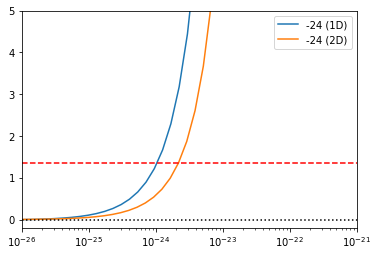

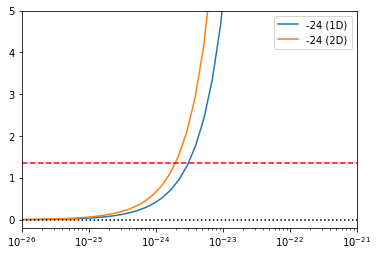

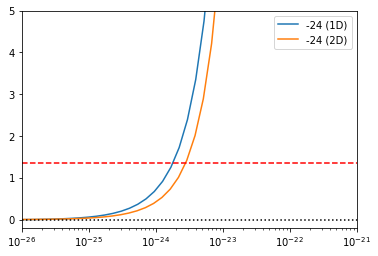

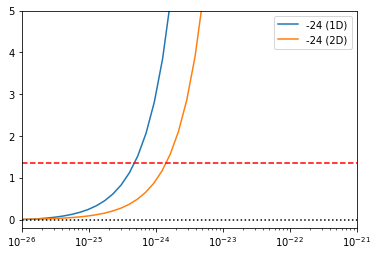

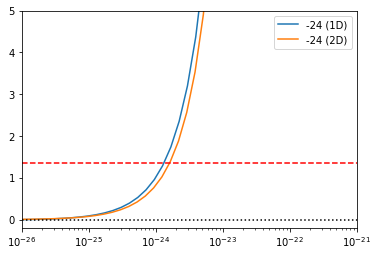

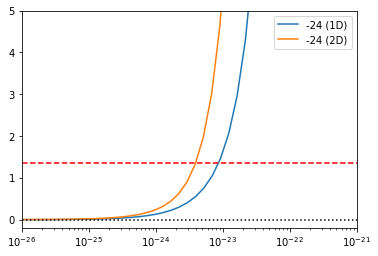

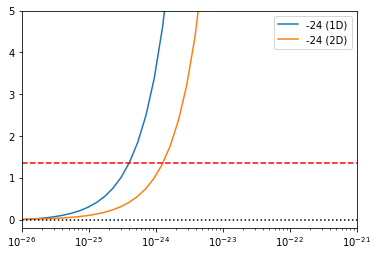

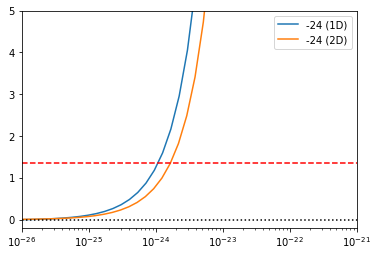

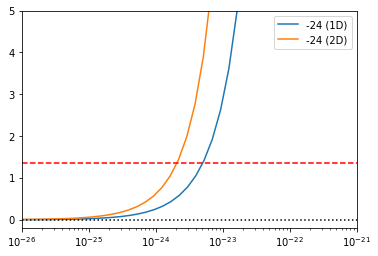

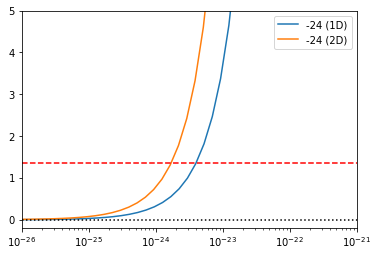

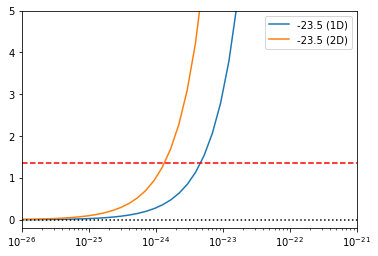

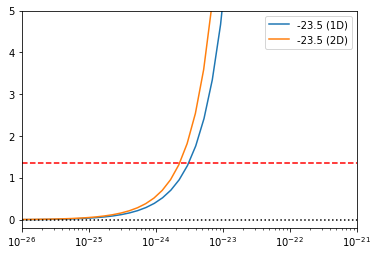

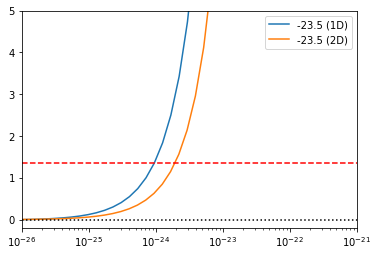

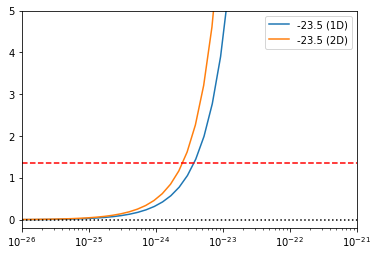

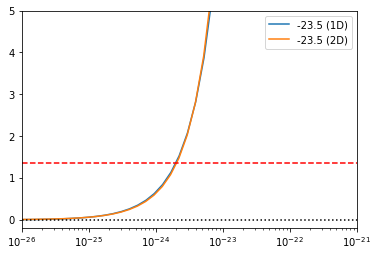

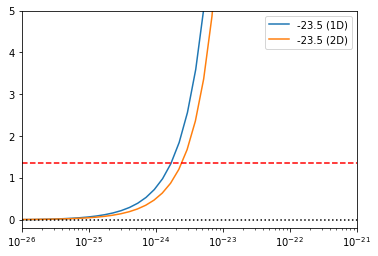

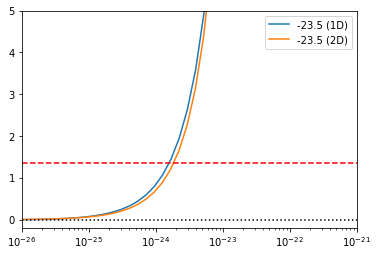

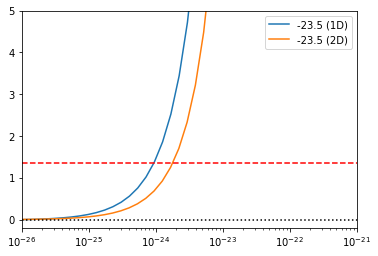

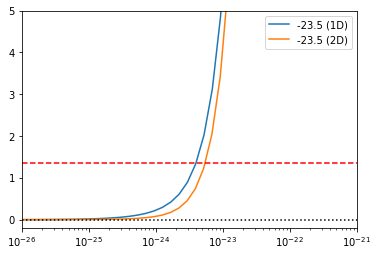

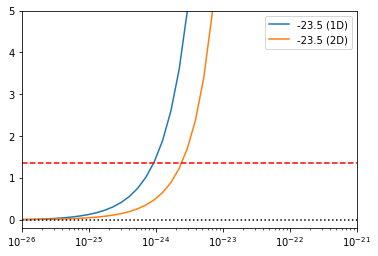

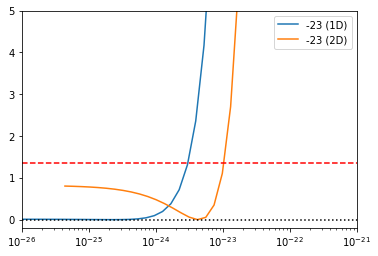

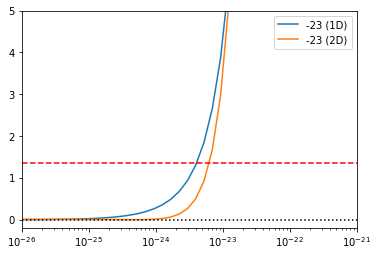

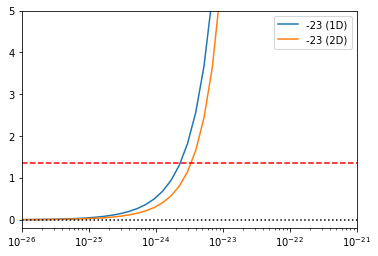

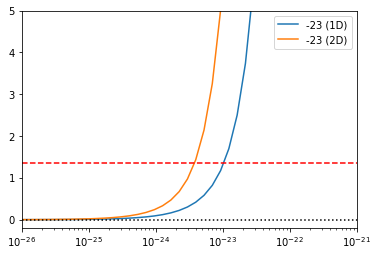

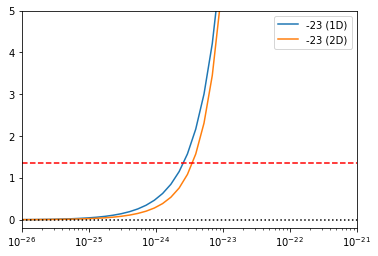

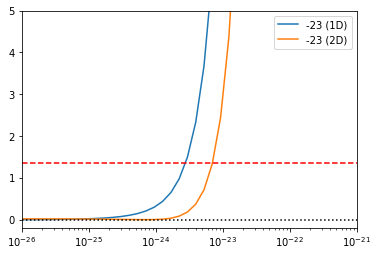

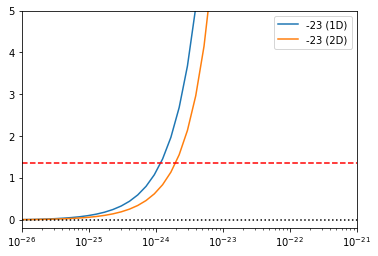

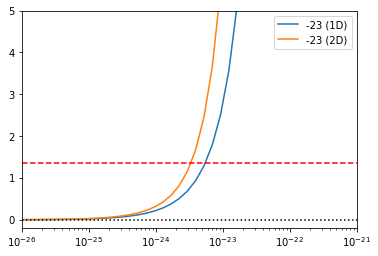

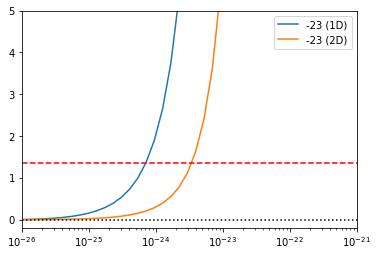

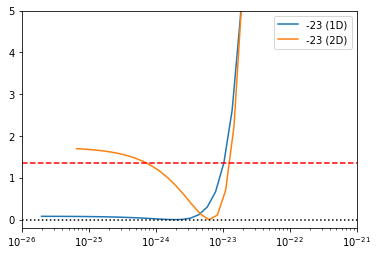

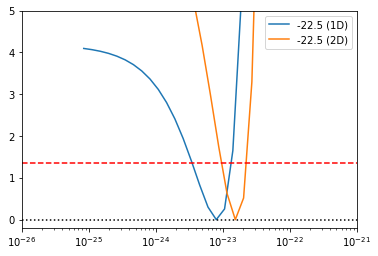

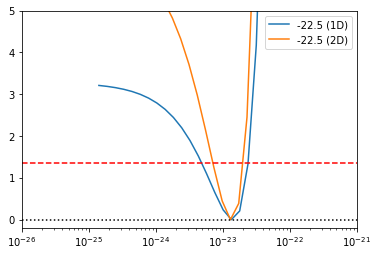

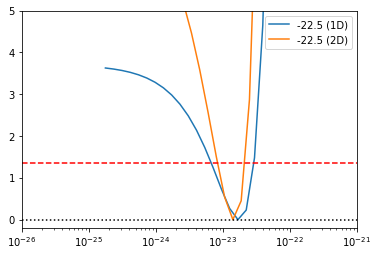

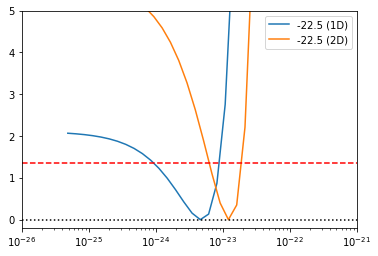

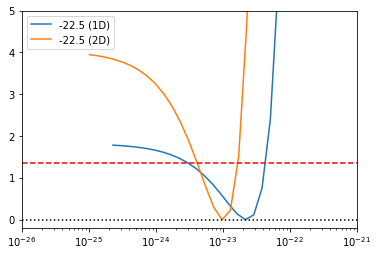

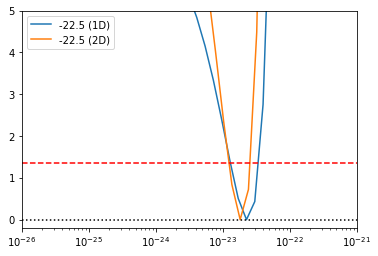

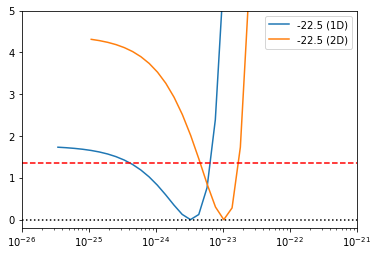

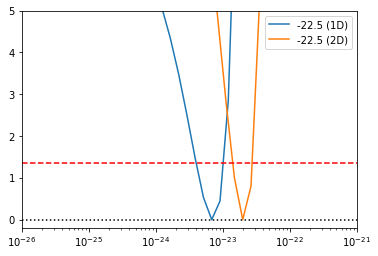

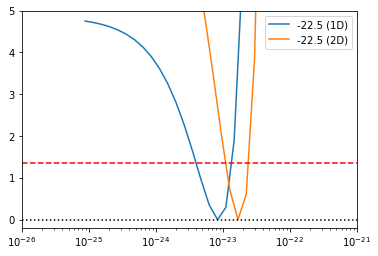

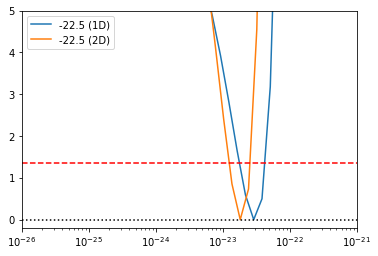

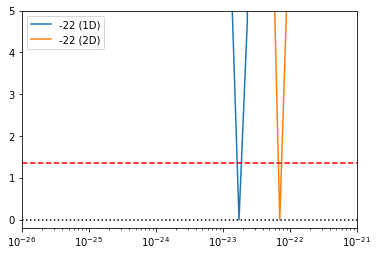

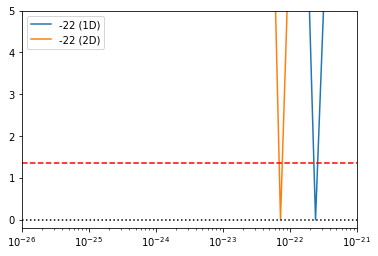

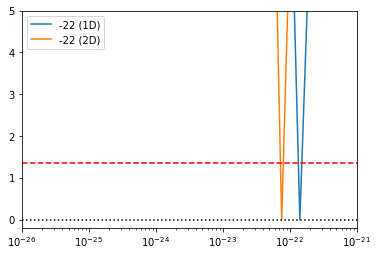

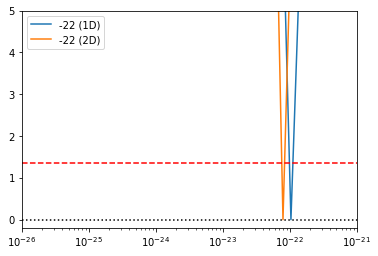

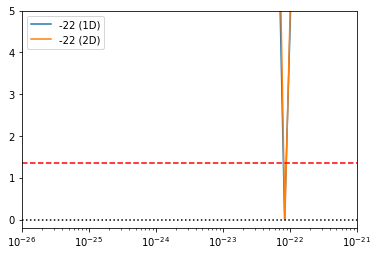

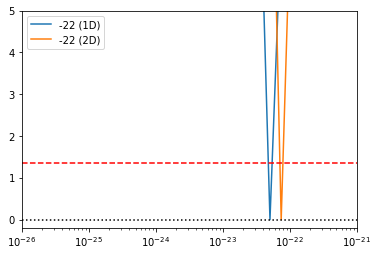

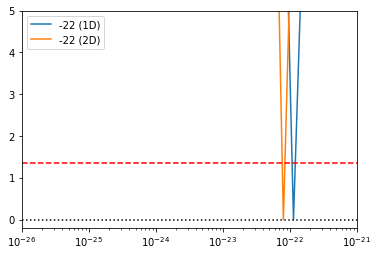

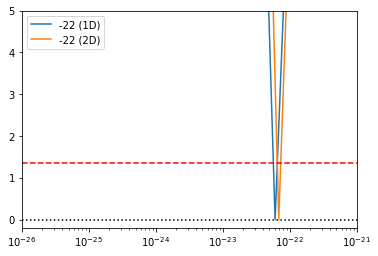

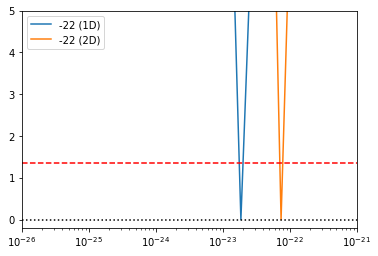

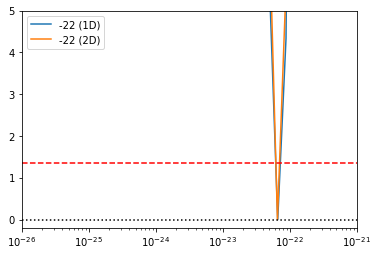

In [46]:
for sigma in sigma_list:
    for i in range(10):
        plt.plot(logl_dist_1d[sigma][i][:,0], logl_dist_1d[sigma][i][:,1]-min(logl_dist_1d[sigma][i][:,1]), label="{} (1D)".format(sigma))
        plt.plot(logl_dist_2d[sigma][i][:,0], logl_dist_2d[sigma][i][:,1]-min(logl_dist_2d[sigma][i][:,1]), label="{} (2D)".format(sigma))
        plt.xscale("log")
        plt.ylim(-0.2, 5)
        plt.xlim(1e-26, 1e-21)
        plt.axhline(0, ls=":", color="k")
        plt.axhline(2.71/2, ls="--", color="r")
        plt.legend()
        plt.show(block=False)